# Aggregation and Grouping

- A fundamental piece of many data analysis tasks is efficient summarization: computing aggregations like `sum`, `mean`, `median`, `min`, and `max`, in which a single number summarizes aspects of a potentially large dataset.

- For convenience, we'll use the same `display` magic function that we used in the previous chapters:

In [2]:
import numpy as np
import pandas as pd

In [3]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/) (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets*, or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [3]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


This has some details on the 1,000+ extrasolar planets discovered up to 2014.

## Simple Aggregation in Pandas

In ["Aggregations: Min, Max, and Everything In Between"](02.04-Computation-on-arrays-aggregates.ipynb), we explored some of the data aggregations available for NumPy arrays.
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [4]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [5]:
ser.sum()

2.811925491708157

In [6]:
ser.mean()

0.5623850983416314

For a `DataFrame`, by default the aggregates return results within each column:

In [7]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [8]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

By specifying the `axis` argument, you can instead aggregate within each row:

In [9]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas `Series` and `DataFrame` objects include all of the common aggregates mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb); in addition, there is a convenience method, `describe`, that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [10]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This method helps us understand the overall properties of a dataset.
For example, we see in the `year` column that although exoplanets were discovered as far back as 1989, half of all planets in the dataset were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which aimed to find eclipsing planets around other stars using a specially designed space telescope.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Returns                         |
|--------------------------|---------------------------------|
| ``count``                | Total number of items           |
| ``first``, ``last``      | First and last item             |
| ``mean``, ``median``     | Mean and median                 |
| ``min``, ``max``         | Minimum and maximum             |
| ``std``, ``var``         | Standard deviation and variance |
| ``mad``                  | Mean absolute deviation         |
| ``prod``                 | Product of all items            |
| ``sum``                  | Sum of all items                |

These are all methods of `DataFrame` and `Series` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the `groupby` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## groupby: Split, Apply, Combine

- Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called `groupby` operation.
- The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, Apply, Combine

- A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

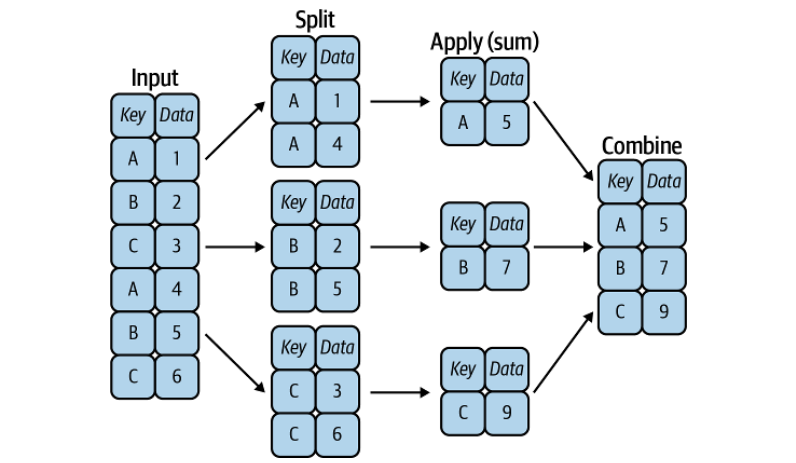

- This illustrates what the `groupby` operation accomplishes:
> - The *split* step involves breaking up and grouping a `DataFrame` depending on the value of the specified key.
> - The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
> - The *combine* step merges the results of these operations into an output array.

- While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated!*
- The power of the `groupby` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather can think about the *operation as a whole*.

In [4]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


- The most basic split-apply-combine operation can be computed with the `groupby` method of the `DataFrame`, passing the name of the desired key column:

In [5]:
df.groupby('key')

- Notice that what is returned is a `DataFrameGroupBy` object, not a set of `DataFrame` objects.
- This object is where the magic is, you can think of it as a special view of the `DataFrame`, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
- This "lazy evaluation" approach means that common aggregates can be implemented efficiently in a way that is almost transparent to the user.

- To produce a result, we can apply an aggregate to this `DataFrameGroupBy` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [13]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


- The `sum` method is just one possibility here; you can apply most Pandas or NumPy aggregation functions, as well as most `DataFrame` operations, as you will see in the following discussion.

### The GroupBy Object

The `GroupBy` object is a flexible abstraction: in many ways, it can be treated as simply a collection of ``DataFrame``s, though it is doing more sophisticated things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a `GroupBy` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in the next section, but before that let's take a look at some of the other functionality that can be used with the basic `GroupBy` operation.

#### Column indexing

The `GroupBy` object supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object.
For example:

In [14]:
planets.groupby('method')

In [15]:
planets.groupby('method')['orbital_period']

Here we've selected a particular `Series` group from the original `DataFrame` group by reference to its column name.
As with the `GroupBy` object, no computation is done until we call some aggregate on the object:

In [16]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The `GroupBy` object supports direct iteration over the groups, returning each group as a `Series` or `DataFrame`:

In [17]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for manual inspection of groups for the sake of debugging, but it is often much faster to use the built-in `apply` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the `GroupBy` object will be passed through and called on the groups, whether they are `DataFrame` or `Series` objects.
For example, using the `describe` method is equivalent to calling `describe` on the `DataFrame` representing each group:

In [18]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.0
       Eclipse Timing Variations           9.0
       Imaging                            38.0
       Microlensing                       23.0
       Orbital Brightness Modulation       3.0
                                         ...  
max    Pulsar Timing                    2011.0
       Pulsation Timing Variations      2007.0
       Radial Velocity                  2014.0
       Transit                          2014.0
       Transit Timing Variations        2014.0
Length: 80, dtype: float64

Looking at this table helps us to better understand the data: for example, the vast majority of planets until 2014 were discovered by the Radial Velocity and Transit methods, though the latter method became common more recently.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

Notice that these dispatch methods are applied *to each individual group*, and the results are then combined within `GroupBy` and returned.
Again, any valid `DataFrame`/`Series` method can be called in a similar manner on the corresponding `GroupBy` object.

- ### Aggregate, Filter, Transform, Apply

- `GroupBy` objects have `aggregate`, `filter`, `transform`, and `apply` methods that efficiently implement a variety of useful operations before combining the grouped data.

- For the purpose of the following subsections, we'll use this ``DataFrame``:

In [7]:
rng = np.random.RandomState(0)

In [8]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

- The `aggregate` method allows for even more flexibility, it can take a string, a function, or a list thereof, and compute all the aggregates at once.

- Here is a quick example combining all of these:

In [9]:
df.groupby('key').aggregate(['min', np.median, max])

C:\Users\MOHEB_MAHER\AppData\Local\Temp\ipykernel_14120\968873422.py:1: FutureWarning: The provided callable <function median at 0x000001E8AD117240> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby('key').aggregate(['min', np.median, max])
C:\Users\MOHEB_MAHER\AppData\Local\Temp\ipykernel_14120\968873422.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df.groupby('key').aggregate(['min', np.median, max])


data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

- Another common pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [21]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


#### Filtering

- A filtering operation allows you to drop data based on the group properties.

- For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [10]:
def filter_func(x):
    return x['data2'].std() > 4

In [11]:
display('df', "df.groupby('key').std()",
        "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

- The filter function should return a Boolean value specifying whether the group passes the filtering.

#### Transformation

- While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
- For such a transformation, the output is the same shape as the input.

- A common example is to center the data by subtracting the group-wise mean:

In [13]:
def center(x):
    return x - x.mean()

In [14]:
df.groupby('key').transform(center)

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


#### The apply method

- The `apply` method lets you apply an arbitrary function to the group results.
- The function should take a `DataFrame` and returns either a Pandas object (e.g., `DataFrame`, `Series`) or a scalar; the behavior of the combine step will be tailored to the type of output returned.

- For example, here is an `apply` operation that normalizes the first column by the sum of the second:

In [15]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

In [17]:
df.groupby('key').apply(norm_by_data2, include_groups=False)

data1  data2
key                   
A   0  0.000000      5
    3  0.375000      3
B   1  0.142857      0
    4  0.571429      7
C   2  0.166667      3
    5  0.416667      9

- `apply` within a `GroupBy` is flexible: the only criterion is that the function takes a `DataFrame` and returns a Pandas object or scalar. What you do in between is up to you!

### Specifying the Split Key

In the simple examples presented before, we split the `DataFrame` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the `DataFrame`. For example:

In [25]:
L = [0, 1, 0, 1, 2, 0]
df.groupby(L).sum()

,data1,data2
0,7,17
1,4,3
2,4,7


Of course, this means there's another, more verbose way of accomplishing the `df.groupby('key')` from before:

In [26]:
df.groupby(df['key']).sum()

,data1,data2
key,,
A,3,8
B,5,7
C,7,12


#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [27]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
key,,
consonant,12,19


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [28]:
df2.groupby(str.lower).mean()

,data1,data2
key,,
a,1.5,4.0
b,2.5,3.5
c,3.5,6.0


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [29]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
key,key,,
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### Grouping Example

As an example of this, in a few lines of Python code we can put all these together and count discovered planets by method and by decade:

In [30]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets: we quickly gain a coarse understanding of when and how extrasolar planets were detected in the years after the first discovery.

I would suggest digging into these few lines of code and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.